# [Workshop: Software Tools from Atomistics to Phase Diagrams](https://workshop.materialsgenomefoundation.org) 

## Day 1 - Atomistic simulations ([pyiron](https://pyiron.org))
**Authors:  <u>Jan Janssen</u>, Tilmann Hickel, Jörg Neugebauer ([Max-Planck-Institut für Eisenforschung](https://www.mpie.de))**

Interactive: **From free energies to phase diagrams**

The scope of this first exercise is to become familar with:
* with the phonopy interface in pyiron to calculate free energies,
* the harmonic and quasi-harmonic approximation and
* how to combine multiple pyiron jobs in one workflow. 

With this last section we have all the necessary tools to calculate phase diagrams. 

## Reminder
In the first session we learned how to create a pyiron project object and then use this pyiron project object to create atomistic structure objects. 

In [1]:
# Import the Project object
from pyiron import Project

In [2]:
# Create a Project object instance for a project named phonons
pr = Project("phonons")

In [3]:
# Create a cubic aluminum fcc structure
al_fcc = pr.create_ase_bulk("Al", cubic=True)

In [4]:
# Confirm the final structure has 4 atoms by calculating 
# the length of the structure object
len(al_fcc) == 4

True

## Harmonic Approximation 
Calculate the phonons at the 0K equilibrium volume and then use the model of the harmonic oscillator to calculate the free energy, heat capacity and entropy contribution. These calculation can again be either executed with density functional theory (DFT) or interatomic potentials. In this workshop we use interatomic potentials to accelerate the process, but the same simulation protocol can also be executed with DFT code as quantum engine. 

### Minimization

In [5]:
# Create a LAMMPS job to relax the structure - here we the regular minimization
# for DFT calculation it is recommended to calculate the energy volume curve 
# to identify the equilibrium volume as discussed in the previous section. 
# Name the minimization job "lmp_mini".
job_mini = pr.create_job(
    job_type=pr.job_type.Lammps,
    job_name="lmp_mini"
)



In [6]:
# Assign the the cubic fcc aluminium structure to the LAMMPS quantum engine job
job_mini.structure = al_fcc

In [7]:
# Set the pressure during the minimization to zero 
job_mini.calc_minimize(pressure=0)

In [8]:
# Execute the minimization
job_mini.run()

/opt/conda/lib/python3.8/site-packages/pyiron/lammps/base.py:229: UserWarning: No potential set via job.potential - use default potential, Al_Mg_Mendelev_eam
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job lmp_mini was saved and received the ID: 82


### Phonon Calculation

In [9]:
# Create a interatomic template job with the LAMMPS quantum engine named lmp
job_lammp_template = pr.create_job(
    job_type=pr.job_type.Lammps,
    job_name="lmp"
)

In [10]:
# Assign the the final structure of the minimization calculation job as input structure
job_lammp_template.structure = job_mini.get_structure()

In [11]:
# Calculate the bulk energy using the template job in a separate calculation named "lmp_bulk"
job_bulk = job_lammp_template.copy_to(
    new_job_name="lmp_bulk", 
    new_database_entry=False
)

In [12]:
# Create a Phonopy job from the LAMMPS quantum engine named phono
phono = job_lammp_template.create_job(
    job_type=pr.job_type.PhonopyJob,
    job_name="phono"
)

In [13]:
# Execute the Phonopy calculation and the bulk calculation
job_bulk.run()
phono.run()

/opt/conda/lib/python3.8/site-packages/pyiron/lammps/base.py:229: UserWarning: No potential set via job.potential - use default potential, Al_Mg_Mendelev_eam
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job lmp_bulk was saved and received the ID: 84
The job phono was saved and received the ID: 85


/opt/conda/lib/python3.8/site-packages/pyiron/lammps/base.py:229: UserWarning: No potential set via job.potential - use default potential, Al_Mg_Mendelev_eam
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job lmp_0 was saved and received the ID: 87


### Density of States

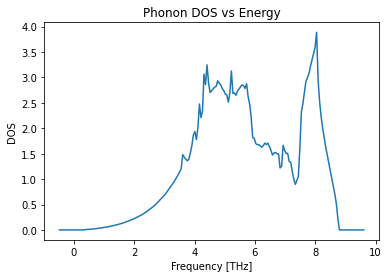

In [14]:
# Plot the density of states over energy 
phono.plot_dos();

### Free energy calculation

In [15]:
# To calculate the thermodynamic properties we define a temperature range
# Starting a 0K up to the 800K using 41 steps. We import numpy and define
# a linear space starting at 0 to 800 with 41 steps. 
import numpy as np
temperatures = np.linspace(0, 800, 41)

In [16]:
# Calculate the thermal properties for a the defined temperature range 
bulk_thermal_properties = phono.get_thermal_properties(temperatures=temperatures) 

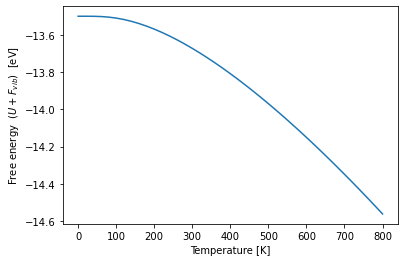

In [17]:
# Import the matplotlib library for plotting. 
import matplotlib.pyplot as plt

# Plot the free energy over temperature by adding the inner bulk energy and the free vibrational energy 
plt.plot(temperatures, job_bulk.output.energy_pot[-1] + bulk_thermal_properties.free_energies)
plt.xlabel("Temperature [K]")
plt.ylabel("Free energy  ($U+F_{vib}$)  [eV]");

### Heat capacity

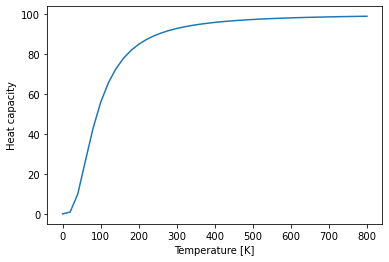

In [18]:
# Plot the heat capacity over temperature
plt.plot(temperatures, bulk_thermal_properties.cv)
plt.xlabel("Temperature [K]")
plt.ylabel("Heat capacity");

### Entropy

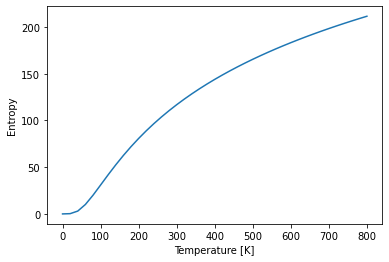

In [19]:
# Plot the entropy over temperature
plt.plot(temperatures, bulk_thermal_properties.entropy)
plt.xlabel("Temperature [K]")
plt.ylabel("Entropy");

## Quasi-harmonic Approximation
The quasi-harmonic approximation includes the thermal volume expansion in contrast to the harmonic approximation which only considers the 0K equilibrium volume. 

### Calculation

In [20]:
# Create a interatomic template job with the LAMMPS quantum engine named lmp_strain
job_strain_template = pr.create_job(
    job_type=pr.job_type.Lammps,
    job_name="lmp_strain"
)

In [21]:
# Assign the the final structure of the minimization calculation job as input structure
job_strain_template.structure = job_mini.get_structure()

In [22]:
# Create a secondary template job to calculate the bulk energy
# The second template job we name lmp_bulk_strain 
job_strain_bulk = job_strain_template.copy_to(
    new_job_name="lmp_bulk_strain", 
    new_database_entry=False
)

In [23]:
# Use this second template job to create a Murnaghan job named murn_strain
murn_strain = job_strain_bulk.create_job(
    job_type=pr.job_type.Murnaghan,
    job_name="murn_strain"
)

In [24]:
# Create a Phonopy job from the original LAMMPS quantum engine named phono_strain
phono_strain = job_strain_template.create_job(
    job_type=pr.job_type.PhonopyJob,
    job_name="phono_strain"
)

In [25]:
# Assign this Phonopy job to a QuasiHarmonicJob to calculate the phonons at multiple volumes
# This QuasiHarmonicJob is named quasi_strain
quasi_strain = phono_strain.create_job(
    job_type=pr.job_type.QuasiHarmonicJob,
    job_name="quasi_strain"
)

In [26]:
# Set the end temperature to be 800K and set the number of temperature steps to 41 
quasi_strain.input["temperature_end"] = 800
quasi_strain.input["temperature_steps"] = 41

In [27]:
# Execute the QuasiHarmonicJob calculation and the bulk calculation
murn_strain.run()
quasi_strain.run()

The job murn_strain was saved and received the ID: 89


/opt/conda/lib/python3.8/site-packages/pyiron/lammps/base.py:229: UserWarning: No potential set via job.potential - use default potential, Al_Mg_Mendelev_eam
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job strain_0_9 was saved and received the ID: 91


/opt/conda/lib/python3.8/site-packages/pyiron/lammps/base.py:229: UserWarning: No potential set via job.potential - use default potential, Al_Mg_Mendelev_eam
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job strain_0_92 was saved and received the ID: 92


/opt/conda/lib/python3.8/site-packages/pyiron/lammps/base.py:229: UserWarning: No potential set via job.potential - use default potential, Al_Mg_Mendelev_eam
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job strain_0_94 was saved and received the ID: 94


/opt/conda/lib/python3.8/site-packages/pyiron/lammps/base.py:229: UserWarning: No potential set via job.potential - use default potential, Al_Mg_Mendelev_eam
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job strain_0_96 was saved and received the ID: 95


/opt/conda/lib/python3.8/site-packages/pyiron/lammps/base.py:229: UserWarning: No potential set via job.potential - use default potential, Al_Mg_Mendelev_eam
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job strain_0_98 was saved and received the ID: 98


/opt/conda/lib/python3.8/site-packages/pyiron/lammps/base.py:229: UserWarning: No potential set via job.potential - use default potential, Al_Mg_Mendelev_eam
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job strain_1_0 was saved and received the ID: 100


/opt/conda/lib/python3.8/site-packages/pyiron/lammps/base.py:229: UserWarning: No potential set via job.potential - use default potential, Al_Mg_Mendelev_eam
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job strain_1_02 was saved and received the ID: 102


/opt/conda/lib/python3.8/site-packages/pyiron/lammps/base.py:229: UserWarning: No potential set via job.potential - use default potential, Al_Mg_Mendelev_eam
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job strain_1_04 was saved and received the ID: 103


/opt/conda/lib/python3.8/site-packages/pyiron/lammps/base.py:229: UserWarning: No potential set via job.potential - use default potential, Al_Mg_Mendelev_eam
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job strain_1_06 was saved and received the ID: 105


/opt/conda/lib/python3.8/site-packages/pyiron/lammps/base.py:229: UserWarning: No potential set via job.potential - use default potential, Al_Mg_Mendelev_eam
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job strain_1_08 was saved and received the ID: 106


/opt/conda/lib/python3.8/site-packages/pyiron/lammps/base.py:229: UserWarning: No potential set via job.potential - use default potential, Al_Mg_Mendelev_eam
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job strain_1_1 was saved and received the ID: 108
job_id:  91 finished
job_id:  92 finished
job_id:  94 finished
job_id:  95 finished
job_id:  98 finished
job_id:  100 finished
job_id:  102 finished
job_id:  103 finished
job_id:  105 finished
job_id:  106 finished
job_id:  108 finished
The job quasi_strain was saved and received the ID: 110
The job strain_0_9 was saved and received the ID: 111


/opt/conda/lib/python3.8/site-packages/pyiron/lammps/base.py:229: UserWarning: No potential set via job.potential - use default potential, Al_Mg_Mendelev_eam
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job lmp_strain_0 was saved and received the ID: 113
The job strain_0_92 was saved and received the ID: 115


/opt/conda/lib/python3.8/site-packages/pyiron/lammps/base.py:229: UserWarning: No potential set via job.potential - use default potential, Al_Mg_Mendelev_eam
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job lmp_strain_0 was saved and received the ID: 116
The job strain_0_94 was saved and received the ID: 118


/opt/conda/lib/python3.8/site-packages/pyiron/lammps/base.py:229: UserWarning: No potential set via job.potential - use default potential, Al_Mg_Mendelev_eam
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job lmp_strain_0 was saved and received the ID: 120
The job strain_0_96 was saved and received the ID: 122


/opt/conda/lib/python3.8/site-packages/pyiron/lammps/base.py:229: UserWarning: No potential set via job.potential - use default potential, Al_Mg_Mendelev_eam
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job lmp_strain_0 was saved and received the ID: 124
The job strain_0_98 was saved and received the ID: 125


/opt/conda/lib/python3.8/site-packages/pyiron/lammps/base.py:229: UserWarning: No potential set via job.potential - use default potential, Al_Mg_Mendelev_eam
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job lmp_strain_0 was saved and received the ID: 126
The job strain_1_0 was saved and received the ID: 127


/opt/conda/lib/python3.8/site-packages/pyiron/lammps/base.py:229: UserWarning: No potential set via job.potential - use default potential, Al_Mg_Mendelev_eam
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job lmp_strain_0 was saved and received the ID: 128
The job strain_1_02 was saved and received the ID: 129


/opt/conda/lib/python3.8/site-packages/pyiron/lammps/base.py:229: UserWarning: No potential set via job.potential - use default potential, Al_Mg_Mendelev_eam
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job lmp_strain_0 was saved and received the ID: 130
The job strain_1_04 was saved and received the ID: 131


/opt/conda/lib/python3.8/site-packages/pyiron/lammps/base.py:229: UserWarning: No potential set via job.potential - use default potential, Al_Mg_Mendelev_eam
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job lmp_strain_0 was saved and received the ID: 132
The job strain_1_06 was saved and received the ID: 133


/opt/conda/lib/python3.8/site-packages/pyiron/lammps/base.py:229: UserWarning: No potential set via job.potential - use default potential, Al_Mg_Mendelev_eam
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job lmp_strain_0 was saved and received the ID: 134
The job strain_1_08 was saved and received the ID: 135


/opt/conda/lib/python3.8/site-packages/pyiron/lammps/base.py:229: UserWarning: No potential set via job.potential - use default potential, Al_Mg_Mendelev_eam
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job lmp_strain_0 was saved and received the ID: 136
The job strain_1_1 was saved and received the ID: 137


/opt/conda/lib/python3.8/site-packages/pyiron/lammps/base.py:229: UserWarning: No potential set via job.potential - use default potential, Al_Mg_Mendelev_eam
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job lmp_strain_0 was saved and received the ID: 138


### Free Energy
To calculate the heat capacity and entropy at constant pressure, the free energy at constant temperature is plotted over volume. The minimum at constant temperature defines the volume of constant pressure. 

In [28]:
# Visualise the temperature dependent free energy over volume using a matplotlib color map
import matplotlib
cmap = matplotlib.cm.get_cmap('coolwarm')

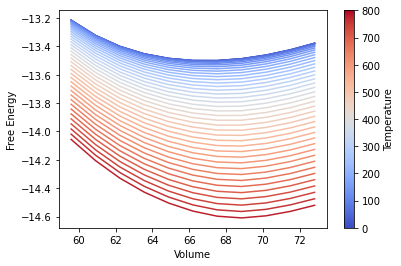

In [29]:
# Iterate over the the output of the QuasiHarmonicJob to plot the temperature dependent free energy over volume 
for i, [t, free_energy, v] in enumerate(
        zip(quasi_strain["output/temperatures"].T, 
            quasi_strain["output/free_energy"].T, 
            quasi_strain["output/volumes"].T)):
    color = cmap(i/len(quasi_strain["output/temperatures"].T))
    # Add the energy of the Murnaghan Job to the vibrational free energy
    plt.plot(v, free_energy + murn_strain["output/energy"], color=color)

# Add labels to the plot     
plt.xlabel("Volume")
plt.ylabel("Free Energy")

# Add a color bar to visualise the temperature dependence 
temperatures = quasi_strain["output/temperatures"]
normalize = matplotlib.colors.Normalize(vmin=temperatures.min(), vmax=temperatures.max())
scalarmappaple = matplotlib.cm.ScalarMappable(norm=normalize, cmap=cmap)
scalarmappaple.set_array(temperatures)
cbar = plt.colorbar(scalarmappaple)
cbar.set_label("Temperature")

### Pressure optimised thermodynamic properties
After calculating the volume expansion from the free energy surface over temperature and volume, the entropy and heat capacity are calculated at these optimised volumes.

In [30]:
# Use the optimise_volume() function of the QuasiHarmonicJob  
v0_lst, free_eng_lst, entropy_lst, cv_lst = quasi_strain.optimise_volume(
    # It requires the output energy of the energy volume curve as additional input 
    bulk_eng=murn_strain["output/energy"]
)
temperature_output_lst = quasi_strain["output/temperatures"][0]

Text(0, 0.5, 'Volume')

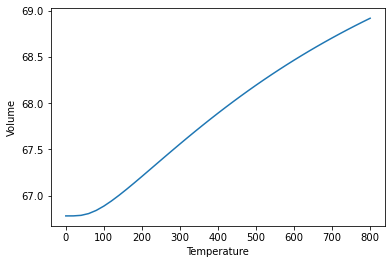

In [31]:
# Plot the finite temperature volume over temperature 
plt.plot(temperature_output_lst, v0_lst)
plt.xlabel("Temperature")
plt.ylabel("Volume")

Text(0, 0.5, 'Free Energy')

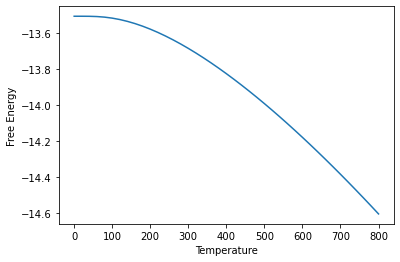

In [32]:
# Plot the pressure optimised free energy over temperature 
plt.plot(temperature_output_lst, free_eng_lst)
plt.xlabel("Temperature")
plt.ylabel("Free Energy")

Text(0, 0.5, 'Entropy')

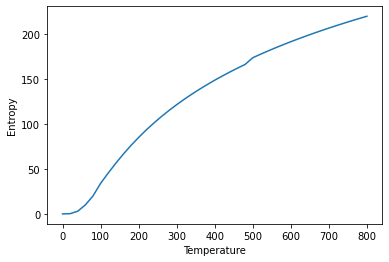

In [33]:
# Plot the pressure optimised entropy over temperature 
plt.plot(temperature_output_lst, entropy_lst)
plt.xlabel("Temperature")
plt.ylabel("Entropy")

Text(0, 0.5, 'Heat Capacity')

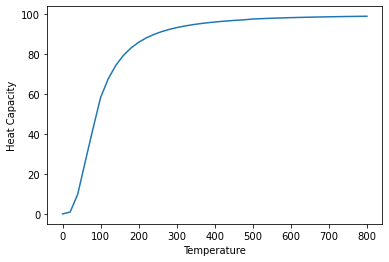

In [34]:
# Plot the pressure optimised heat capacity over temperature 
plt.plot(temperature_output_lst, cv_lst)
plt.xlabel("Temperature")
plt.ylabel("Heat Capacity")

## Concentration dependence 
With the temperature dependence of a unary discussed above the next step is the concentration dependence. For the concentration dependence we use the special quasi-random structures introduced in the first section to calculate mixed structures. Here we select the Ni-Cr phase diagram, which can be calculated using the `2018--Howells-C-A--Cr-Ni--LAMMPS--ipr1` potential. 

### Create Endmembers
Start by creating the endmembers of both phases the nickel fcc endmember and the chromium bcc endmember.

In [35]:
# Create the Nickel fcc endmember 
ni_fcc = pr.create_ase_bulk("Ni", cubic=True)

# Create the Chromium bcc endmember 
cr_bcc_small = pr.create_ase_bulk("Cr", cubic=True)

# Compare the length of both structures
len(ni_fcc), len(cr_bcc_small)

(4, 2)

In [36]:
# Repeat the bcc cell to have the same number of atoms as the fcc cell
cr_bcc = cr_bcc_small.repeat([1, 1, 2])

# Compare the length of both structure
len(cr_bcc) == len(ni_fcc)

True

### Select concentrations 
One advantage of atomistic simulation is the ability to calculate free energies of unstable phases. In this case we calculate both the fcc phase and the bcc phase for all temperature ranges. Starting at 0% Cr up to 100%. 

In [37]:
# Create 3 mixed concentrations for a 4 atom cell within the range 0.0 to 1.0 
# for example these could be 0.25, 0.5 and 0.75
concentration_lst = [0.25, 0.5, 0.75]

In [38]:
# Create an FCC Cr lattice by replacing all elements of the FCC Ni lattice with Cr
cr_fcc = ni_fcc.copy()
cr_fcc[:] = "Cr"

In [39]:
# Create an BCC Ni lattice by replacing all elements of the BCC Cr lattice with Ni
ni_bcc = cr_bcc.copy()
ni_bcc[:] = "Ni"

In [40]:
# Create a list of all concentrations 
concentration_total_lst = [0.0] + concentration_lst + [1.0]

### SQS Structures
To calculate SQS structures for multiple concentrations the SQSMaster job is used, it takes an SQS job as an input in addtion to a list of concentrations. Here it is used to calculate SQS structures for both the FCC phase and the BCC phase.

#### FCC

In [41]:
# Create an SQS job named sqs_job_ni
sqs_job_ni = pr.create_job(
    job_type=pr.job_type.SQSJob, 
    job_name="sqs_job_ni"
)

In [42]:
# Assign the cubic nickel fcc structure to the SQS job
sqs_job_ni.structure = ni_fcc

In [43]:
# Limit the number of iterations to 1000
sqs_job_ni.input['iterations'] = 1000

In [44]:
# Create an SQSMaster named sqs_master_ni
master_ni = sqs_job_ni.create_job(
    job_type=pr.job_type.SQSMaster, 
    job_name="sqs_master_ni"
)

In [45]:
# Assign the mixed concentration list defined above - not the total concentration list which includes the end members
master_ni.input["fraction_lst"] = concentration_lst
master_ni.input["species_one"] = "Ni"
master_ni.input["species_two"] = "Cr"

In [46]:
# Execute the calculation
master_ni.run()

The job sqs_master_ni was saved and received the ID: 139
The job sqs_0_25 was saved and received the ID: 140
Threads used: 1
The job sqs_0_5 was saved and received the ID: 141
Threads used: 1
The job sqs_0_75 was saved and received the ID: 142
Threads used: 1


#### BCC 

In [47]:
# Create an SQS job named sqs_job_cr
sqs_job_cr = pr.create_job(
    job_type=pr.job_type.SQSJob, 
    job_name="sqs_job_cr"
)

In [48]:
# Assign the cubic chromium bcc structure to the SQS job
sqs_job_cr.structure = cr_bcc

In [49]:
# Limit the number of iterations to 1000
sqs_job_cr.input['iterations'] = 1e4

In [50]:
# Create an SQSMaster named sqs_master_cr
master_cr = sqs_job_cr.create_job(
    job_type=pr.job_type.SQSMaster, 
    job_name="cr_sqs_master"
)

In [51]:
# Assign the mixed concentration list defined above - not the total concentration list which includes the end members
master_cr.input["fraction_lst"] = concentration_lst
master_cr.input["species_one"] = "Ni"
master_cr.input["species_two"] = "Cr"

In [52]:
# Execute the calculation
master_cr.run()

The job cr_sqs_master was saved and received the ID: 143
The job sqs_0_25 was saved and received the ID: 144
Threads used: 1
The job sqs_0_5 was saved and received the ID: 145
Threads used: 1
The job sqs_0_75 was saved and received the ID: 146
Threads used: 1


### Collect structures
At this point ten structures have been generated five for each phase. Now each of these structures has to be minimized to apply the quasi-harmonic approximation for each of them. In the interest of time this step is skipped here and we only compile the list of structures.

In [53]:
# Combine the end members with the structures from the SQS masters 
# to have a total of five structures for each phase
structure_fcc_lst = [ni_fcc] + master_ni.list_structures() + [cr_fcc]
structure_bcc_lst = [ni_bcc] + master_cr.list_structures() + [cr_bcc]

len(structure_fcc_lst) == len(structure_bcc_lst)

True

## Summary
In this section you learned: 
* how to calculate free energies using the harmonic and the quasi-harmonic approximation. 
* how hierachical workflows can be constructed in pyiron by combining multiple master jobs. 
* and how to generate mixed phases with special quasi random structures. 

Suggestions: 
* Calculate the concentration dependent volume expansion for both the FCC and the BCC phase. 
* Calculate the harmonic approximation for a single SQS structure. As the mixed phase breaks the symmetry additional displacments are necessary. Phonopy automatically identifies the necessary displacements, but these calculation take more time. 
* Use the option `job.server.run_mode.interactive=True` for the LAMMPS jobs before they are assigned to the phonopy jobs to accelerate the calculations by using LAMMPS as a C-library rather than calling the executable by writing output and input files. 